In [1]:
import json, random, math, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import librosa
from torch.utils.data import Dataset, DataLoader


In [2]:
# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Audio params
SR = 16000
N_MELS = 80
N_FFT = 1024
HOP = 256
T = 128  # frames fixos

# Treino
BATCH_SIZE = 128   # ajuste: 16 se ficar pesado
EPOCHS = 15        # só pra começar
LR = 1e-3

# Beta-VAE / anti-collapse
BETA_MAX = 2.0
WARMUP_STEPS = 500   # com DataLoader faz sentido ser maior
FREE_BITS = 0.5      # 0.5 ou 1.0 (0.5 costuma ser mais suave)

# Paths (ajuste se necessário)
DATA_ROOT = Path("../data/nsynth-valid.jsonwav/nsynth-valid")
AUDIO_DIR = DATA_ROOT / "audio"
JSON_PATH = DATA_ROOT / "examples.json"

print("AUDIO_DIR exists:", AUDIO_DIR.exists())
print("JSON_PATH exists:", JSON_PATH.exists())


device: cuda
AUDIO_DIR exists: True
JSON_PATH exists: True


In [3]:
with open(JSON_PATH, "r") as f:
    examples = json.load(f)

keys = list(examples.keys())
random.shuffle(keys)

val_ratio = 0.1
n_val = int(len(keys) * val_ratio)

val_keys = keys[:n_val]
train_keys = keys[n_val:]

print("Total:", len(keys))
print("Train:", len(train_keys))
print("Val  :", len(val_keys))


Total: 12678
Train: 11411
Val  : 1267


In [ ]:
from tqdm import tqdm
import os

CACHE_DIR = Path("../data/nsynth_mel_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def cache_one(key: str):
    out_path = CACHE_DIR / f"{key}.pt"
    if out_path.exists():
        return

    wav_path = AUDIO_DIR / f"{key}.wav"
    audio, sr = librosa.load(wav_path, sr=SR, mono=True)

    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = np.clip(log_mel, -80.0, 0.0)

    x = (log_mel + 80.0) / 80.0   # [0, 1]
    x = 2.0 * x - 1.0             # [-1, 1]

    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1,80,time)

    # pad/crop to T
    time_frames = x.shape[-1]
    if time_frames >= T:
        x = x[:, :, :T]
    else:
        x = F.pad(x, (0, T - time_frames))

    torch.save(x, out_path)

# escolha um subset primeiro se quiser testar rápido
# keys_to_cache = train_keys[:5000] + val_keys[:1000]
keys_to_cache = train_keys + val_keys

for k in tqdm(keys_to_cache, desc="Caching log-mels"):
    cache_one(k)

print("Cache ready at:", CACHE_DIR)


Caching log-mels: 100%|██████████| 12678/12678 [00:00<00:00, 188894.09it/s]

Cache ready at: ../data/nsynth_mel_cache


In [5]:
def wav_to_logmel_norm(audio: np.ndarray, sr: int) -> np.ndarray:
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = np.clip(log_mel, -80.0, 0.0)

    # [-80,0] -> [0,1] -> [-1,1]
    x = (log_mel + 80.0) / 80.0
    x = 2.0 * x - 1.0
    return x  # (80, time)


In [6]:
### Original Data Loader (on-the-fly processing)

class NSynthLogMelDataset(Dataset):
    def __init__(self, keys, examples, audio_dir: Path):
        self.keys = keys
        self.examples = examples
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        wav_path = self.audio_dir / f"{k}.wav"

        audio, sr = librosa.load(wav_path, sr=SR, mono=True)
        x = wav_to_logmel_norm(audio, sr)  # (80, time)

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1, 80, time)

        # pad/crop to (1,80,T)
        time_frames = x.shape[-1]
        if time_frames >= T:
            x = x[:, :, :T]
        else:
            x = F.pad(x, (0, T - time_frames))

        pitch = self.examples[k]["pitch"]
        family = self.examples[k]["instrument_family"]

        return x, pitch, family, k
    
### Cached version Data Loader

class CachedNSynthDataset(Dataset):
    def __init__(self, keys, examples, cache_dir: Path):
        self.keys = keys
        self.examples = examples
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)

        pitch = self.examples[k]["pitch"]
        family = self.examples[k]["instrument_family"]
        return x, pitch, family, k


In [7]:
train_ds = CachedNSynthDataset(train_keys, examples, CACHE_DIR)
val_ds   = CachedNSynthDataset(val_keys, examples, CACHE_DIR)

pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=2
)

# sanity check
x, pitch, family, k = next(iter(train_loader))
print("batch x:", tuple(x.shape), "pitch:", pitch[:5].tolist(), "family:", family[:5].tolist())


/tmp/ipykernel_193265/3765502276.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)
/tmp/ipykernel_193265/3765502276

batch x: (128, 1, 80, 128) pitch: [61, 59, 40, 89, 61] family: [3, 0, 1, 6, 0]


In [8]:
class VAEConvEncoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)  # -> (16,40,64)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) # -> (32,20,32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # -> (64,10,16)

        self.flatten_dim = 64 * 10 * 16
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.flatten(start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        self.C, self.H, self.W = 64, 10, 16
        self.flatten_dim = self.C * self.H * self.W

        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z).view(z.size(0), self.C, self.H, self.W)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_hat = self.deconv3(x)
        return x_hat

class VAE(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        self.encoder = VAEConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z


In [9]:
def kl_raw(mu, logvar):
    # per sample
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

def vae_loss(x_hat, x, mu, logvar, beta: float, free_bits: float):
    recon = F.mse_loss(x_hat, x, reduction="mean")

    kl_ps = kl_raw(mu, logvar)         # (B,)
    kl_mean = kl_ps.mean()

    # free-bits: clamp the KL per sample
    kl_fb = torch.clamp(kl_ps, min=free_bits).mean()

    total = recon + beta * kl_fb
    return total, recon, kl_mean, kl_fb

def beta_schedule(global_step: int):
    # linear warmup 0 -> BETA_MAX
    return BETA_MAX * min(1.0, global_step / WARMUP_STEPS)


In [10]:
vae = VAE(latent_dim=32).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

global_step = 0

for epoch in range(1, EPOCHS + 1):
    vae.train()
    t0 = time.time()

    tr_total = tr_recon = tr_kl_raw = tr_kl_fb = 0.0
    n_batches = 0

    for x, pitch, family, k in train_loader:
        x = x.to(device, non_blocking=True)
        beta = beta_schedule(global_step)

        x_hat, mu, logvar, z = vae(x)
        total, recon, kl_mean, kl_fb = vae_loss(x_hat, x, mu, logvar, beta, FREE_BITS)

        opt.zero_grad()
        total.backward()
        opt.step()

        tr_total += float(total)
        tr_recon += float(recon)
        tr_kl_raw += float(kl_mean)
        tr_kl_fb += float(kl_fb)
        n_batches += 1
        global_step += 1

        # log ocasional
        if global_step % 200 == 0:
            print(f"[step {global_step}] beta={beta:.3f} total={float(total):.3f} recon={float(recon):.3f} kl_raw={float(kl_mean):.3f} kl_fb={float(kl_fb):.3f}")

    # médias treino
    tr_total /= n_batches
    tr_recon /= n_batches
    tr_kl_raw /= n_batches
    tr_kl_fb /= n_batches

    # validação
    vae.eval()
    va_total = va_recon = va_kl_raw = va_kl_fb = 0.0
    va_batches = 0

    with torch.no_grad():
        for x, pitch, family, k in val_loader:
            x = x.to(device, non_blocking=True)
            beta = beta_schedule(global_step)  # ok usar o step atual

            x_hat, mu, logvar, z = vae(x)
            total, recon, kl_mean, kl_fb = vae_loss(x_hat, x, mu, logvar, beta, FREE_BITS)

            va_total += float(total)
            va_recon += float(recon)
            va_kl_raw += float(kl_mean)
            va_kl_fb += float(kl_fb)
            va_batches += 1

    va_total /= va_batches
    va_recon /= va_batches
    va_kl_raw /= va_batches
    va_kl_fb /= va_batches

    dt = time.time() - t0
    print(f"\nEpoch {epoch}/{EPOCHS} ({dt:.1f}s)")
    print(f"  Train: total={tr_total:.3f} recon={tr_recon:.3f} kl_raw={tr_kl_raw:.3f} kl_fb={tr_kl_fb:.3f}")
    print(f"  Val  : total={va_total:.3f} recon={va_recon:.3f} kl_raw={va_kl_raw:.3f} kl_fb={va_kl_fb:.3f}\n")


/tmp/ipykernel_193265/3765502276.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(self.cache_dir / f"{k}.pt")  # (1,80,T)
/tmp/ipykernel_193265/3765502276


Epoch 1/15 (1.3s)
  Train: total=0.393 recon=0.301 kl_raw=0.356 kl_fb=0.538
  Val  : total=0.421 recon=0.237 kl_raw=0.356 kl_fb=0.510


Epoch 2/15 (0.7s)
  Train: total=0.506 recon=0.236 kl_raw=0.373 kl_fb=0.503
  Val  : total=0.589 recon=0.229 kl_raw=0.363 kl_fb=0.501

[step 200] beta=0.796 total=0.620 recon=0.222 kl_raw=0.379 kl_fb=0.500

Epoch 3/15 (0.7s)
  Train: total=0.690 recon=0.238 kl_raw=0.338 kl_fb=0.503
  Val  : total=0.784 recon=0.244 kl_raw=0.272 kl_fb=0.500


Epoch 4/15 (0.7s)
  Train: total=0.876 recon=0.244 kl_raw=0.282 kl_fb=0.503
  Val  : total=0.948 recon=0.228 kl_raw=0.382 kl_fb=0.500

[step 400] beta=1.596 total=1.027 recon=0.227 kl_raw=0.416 kl_fb=0.501

Epoch 5/15 (0.8s)
  Train: total=1.028 recon=0.218 kl_raw=0.406 kl_fb=0.501
  Val  : total=1.114 recon=0.213 kl_raw=0.439 kl_fb=0.500


Epoch 6/15 (0.7s)
  Train: total=1.180 recon=0.207 kl_raw=0.439 kl_fb=0.501
  Val  : total=1.203 recon=0.203 kl_raw=0.440 kl_fb=0.500

[step 600] beta=2.000 total=1.198 recon=0.

# Measuring Timbre Space

In [11]:
vae.eval()

N_SAMPLES = 2000
mus = []
pitches = []
families = []
keys = []

with torch.no_grad():
    for x, pitch, family, k in tqdm(val_loader, desc="Extracting mu"):
        x = x.to(device, non_blocking=True)

        # Forward do VAE: ajuste conforme seu forward retorna
        # Esperado: x_hat, mu, logvar, z  (ou algo parecido)
        out = vae(x)

        # --- Ajuste aqui conforme seu modelo ---
        # Caso seu forward retorne tupla:
        # x_hat, mu, logvar, z = out
        # Caso retorne dict: mu = out["mu"]
        if isinstance(out, (tuple, list)):
            # tente os formatos mais comuns
            if len(out) == 4:
                _, mu, _, _ = out
            elif len(out) == 3:
                _, mu, _ = out
            else:
                raise RuntimeError(f"Unexpected VAE output length: {len(out)}")
        elif isinstance(out, dict):
            mu = out["mu"]
        else:
            raise RuntimeError(f"Unexpected VAE output type: {type(out)}")
        # --- fim do ajuste ---

        mus.append(mu.detach().cpu().numpy())
        pitches.append(np.array(pitch))
        families.append(np.array(family))
        keys.extend(list(k))

        if sum(m.shape[0] for m in mus) >= N_SAMPLES:
            break

mu_np = np.concatenate(mus, axis=0)[:N_SAMPLES]
pitch_np = np.concatenate(pitches, axis=0)[:N_SAMPLES]
family_np = np.concatenate(families, axis=0)[:N_SAMPLES]
keys = keys[:N_SAMPLES]

print("mu:", mu_np.shape, "pitch:", pitch_np.shape, "family:", family_np.shape)
print("mu mean/std:", mu_np.mean(), mu_np.std())
print("pitch min/max:", pitch_np.min(), pitch_np.max())
print("unique families:", np.unique(family_np))


Extracting mu:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_193265/3765628835.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pitches.append(np.array(pitch))
/tmp/ipykernel_193265/3765628835.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  families.append(np.array(family))
Extracting mu: 100%|██████████| 10/10 [00:00<00:00, 117.30it/s]

mu: (1267, 32) pitch: (1267,) family: (1267,)
mu mean/std: -0.0062739323 0.11743237
pitch min/max: 9 116
unique families: [ 0  1  2  3  4  5  6  7  8 10]


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
mu_pca = pca.fit_transform(mu_np)

print("PCA explained variance ratio:", pca.explained_variance_ratio_, "sum:", pca.explained_variance_ratio_.sum())


PCA explained variance ratio: [0.8801801  0.10969663] sum: 0.98987675


In [13]:

import umap

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)
mu_umap = umap_model.fit_transform(mu_np)

print("UMAP:", mu_umap.shape)


/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP: (1267, 2)


In [14]:

import pandas as pd
import plotly.express as px


In [15]:
df = pd.DataFrame({
    "x_pca": mu_pca[:, 0],
    "y_pca": mu_pca[:, 1],
    "x_umap": mu_umap[:, 0],
    "y_umap": mu_umap[:, 1],
    "pitch": pitch_np.astype(int),
    "family": family_np.astype(int),
    "key": keys,
})

df.head()


,x_pca,y_pca,x_umap,y_umap,pitch,family,key
0,0.871725,0.013814,12.725430,6.684835,49,4,keyboard_electronic_001-049-127
1,1.120987,-0.050733,15.776008,4.523525,42,0,bass_synthetic_009-042-025
2,-0.423855,-0.009032,0.910630,5.577631,64,3,guitar_acoustic_014-064-075
3,0.131087,-0.032604,7.371798,7.039908,60,1,brass_acoustic_015-060-050
4,-0.420126,-0.010431,1.205086,5.303974,51,4,keyboard_synthetic_000-051-050


In [16]:
import nbformat
fig = px.scatter(
    df,
    x="x_pca",
    y="y_pca",
    color="pitch",
    hover_data=["key", "family", "pitch"],
    title="PCA(mu) — colored by pitch",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [17]:
df["family_str"] = df["family"].astype(str)

fig = px.scatter(
    df,
    x="x_pca",
    y="y_pca",
    color="family_str",
    hover_data=["key", "family", "pitch"],
    title="PCA(mu) — colored by instrument_family",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [18]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="pitch",
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) — colored by pitch",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [19]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="family_str",
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) — colored by instrument_family",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=6))
fig.show()


In [20]:
fig = px.scatter(
    df,
    x="x_umap",
    y="y_umap",
    color="pitch",
    facet_col="family_str",
    facet_col_wrap=4,
    hover_data=["key", "family", "pitch"],
    title="UMAP(mu) faceted by instrument_family (color=pitch)",
    opacity=0.8,
)
fig.update_traces(marker=dict(size=4))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()


# Tests

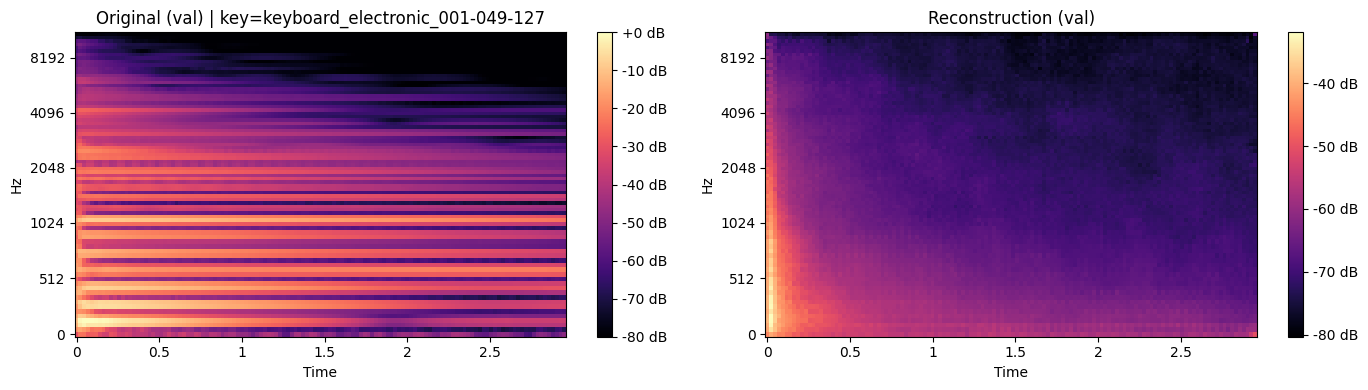

In [85]:
import matplotlib.pyplot as plt
import librosa.display

def denormalize_db(x_norm):
    return ((x_norm + 1.0) / 2.0) * 80.0 - 80.0

vae.eval()
x, pitch, family, k = next(iter(val_loader))
x = x.to(device, non_blocking=True)

with torch.no_grad():
    x_hat, mu, logvar, z = vae(x)

i = 0
orig = denormalize_db(x[i,0].cpu().numpy())
rec  = denormalize_db(x_hat[i,0].cpu().numpy())

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
img1 = librosa.display.specshow(orig, ax=axs[0], x_axis="time", y_axis="mel")
axs[0].set_title(f"Original (val) | key={k[i]}")
fig.colorbar(img1, ax=axs[0], format="%+2.0f dB")

img2 = librosa.display.specshow(rec, ax=axs[1], x_axis="time", y_axis="mel")
axs[1].set_title("Reconstruction (val)")
fig.colorbar(img2, ax=axs[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [12]:
ckpt = {
    "model_state": vae.state_dict(),
    "config": {
        "SR": SR, "N_MELS": N_MELS, "N_FFT": N_FFT, "HOP": HOP, "T": T,
        "BATCH_SIZE": BATCH_SIZE, "LR": LR,
        "BETA_MAX": BETA_MAX, "WARMUP_STEPS": WARMUP_STEPS, "FREE_BITS": FREE_BITS,
        "latent_dim": 32,
        "seed": SEED,
    },
    "global_step": global_step,
}

out_path = Path("vae_nsynth_ckpt.pt")
torch.save(ckpt, out_path)
print("Saved:", out_path)


Saved: vae_nsynth_ckpt.pt
